In [44]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()

H = 3.5
K_d = 2.0
Droop = 0.05
T_g = 1.0

m.t = ContinuousSet(bounds=(0,10)) 

m.Df   = Var(m.t, bounds=(-1,1))
m.p_g  = Var(m.t, bounds=(-1,1))
#m.p_f  = Var(m.t, bounds=(-1,1))
m.p_nc = Var(m.t, initialize=0.0,bounds=(-0.1,0.1))
m.e_nc = Var(m.t, initialize=0.4,bounds=(0.0,1.0))

m.dDf   = DerivativeVar(m.Df)
m.dp_g  = DerivativeVar(m.p_g)
m.de_nc = DerivativeVar(m.e_nc)

#m.obj = Objective(expr=m.p_nc[10]**2)

def objective_rule(M):
    e = 0
    for i in range(200):
        p = M.p_nc[i]
        e +=(p)**2    
    return  e
m.objective = Objective(rule=objective_rule, sense=minimize, doc='Define objective function')



def _dDf(M,i):
    if i == 0:
        return Constraint.Skip
    #M.p_f[i] = -1.0/Droop*M.Df[i]
    return M.dDf[i] == 1.0/(2.0*H)*(M.p_g[i] + M.p_nc[i] - 0.2 - K_d*M.Df[i])
m.dDfcon = Constraint(m.t, rule=_dDf)

def _dp_g(M,i):
    if i == 0:
        return Constraint.Skip
    
    return M.dp_g[i] == 1.0/T_g*(-1.0/Droop*M.Df[i]- M.p_g[i])
m.xdp_gcon = Constraint(m.t, rule=_dp_g)

def _de_nc(M,i):
    if i == 0:
        return Constraint.Skip
    return M.de_nc[i] == - M.p_nc[i]
m.de_nccon = Constraint(m.t, rule=_de_nc)


def _init(M):
    yield M.Df[0]  == 0.0
    yield M.p_g[0] == 0.0
    yield M.p_nc[0] == 0.0
    #yield M.p_f[0] == 0.0
    yield M.e_nc[0] == 0.4
    yield ConstraintList.End
m.init_conditions = ConstraintList(rule=_init)


ERROR: Rule failed when generating expression for objective objective:
	KeyError: "Error accessing indexed component: Index '1' is not valid for array component 'p_nc'"
ERROR: Constructing component 'objective' from data=None failed:
	KeyError: "Error accessing indexed component: Index '1' is not valid for array component 'p_nc'"


KeyError: "Error accessing indexed component: Index '1' is not valid for array component 'p_nc'"

In [37]:
# Discretize model using Backward Finite Difference method
# discretizer = TransformationFactory('dae.finite_difference')
# discretizer.apply_to(m,nfe=20,scheme='BACKWARD')

# Discretize model using Orthogonal Collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=50,ncp=3,scheme='LAGRANGE-RADAU')
discretizer.reduce_collocation_points(m,var=m.p_nc,ncp=1,contset=m.t)

solver=SolverFactory('ipopt')

results = solver.solve(m,tee=True)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Common Public License (CPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.7.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     3803
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:     1053
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      603
                

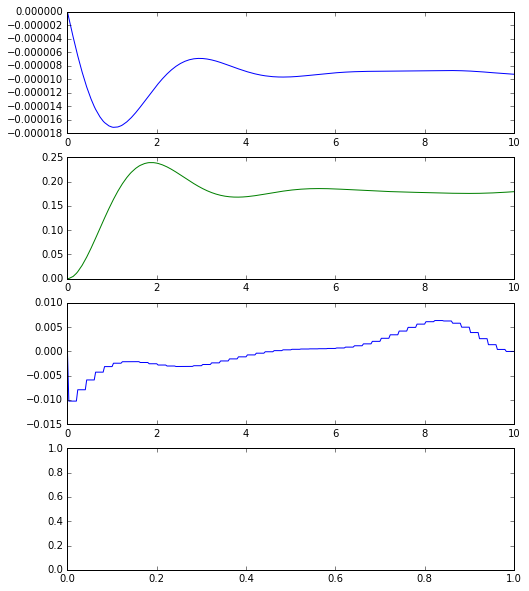

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

Df_list = []
t_list=[]
p_g_list=[]
p_f_list=[]
p_nc_list=[]
e_nc_list=[]

#print(sorted(m.t))

for i in sorted(m.t):
    t_list.append(i)
    Df_list.append(value(m.Df[i]))
    p_g_list.append(value(m.p_g[i]))
    p_nc_list.append(value(m.p_nc[i]))
    e_nc_list.append(value(m.e_nc[i]))
   # p_f_list.append(value(m.p_f[i]))
    
    
Df = np.array(Df_list)
p_g = np.array(p_g_list)
p_f = np.array(p_f_list)
p_nc = np.array(p_nc_list)
t = np.array(t_list)


fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4, figsize=(8,10))   # creates a figure with one axe

ax0.plot(t,Df/1.0e3)
#ax1.plot(t,p_f, 'r', lw=1)
ax1.plot(t,p_g, 'g', lw=1)
ax2.plot(t,p_nc, 'b', lw=1)
#ax3.plot(t,e_nc, 'b', lw=1)
plt.show()

#fig, (ax0,ax1) = plt.subplots(nrows=2)   # creates a figure with one axe

#ax0.plot(t,u/1.0e3) 
#ax1.plot(t,p/1.0e6) 
#plt.show()
